Notebook purpose

- Explore entropy scores

In [2]:
import os
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [3]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 1.87 seconds
Time for read_sample    : 3.36 minutes
(7,531,116, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569


# Cross-sectional entropy

## Overview

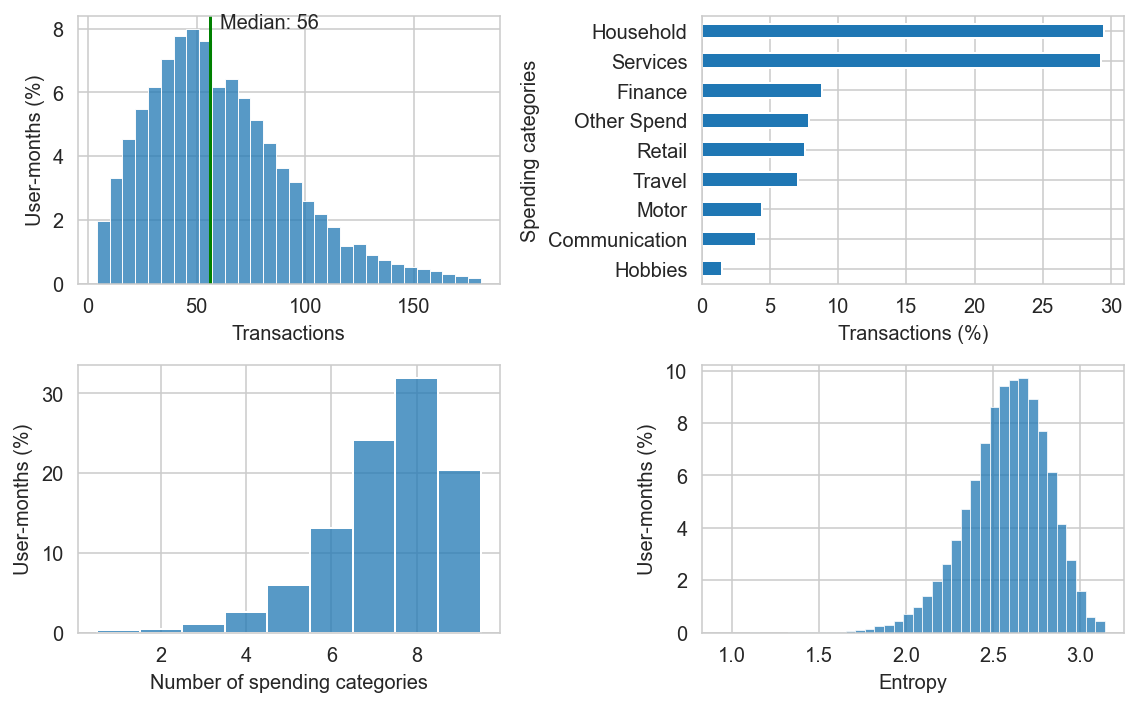

In [7]:
data = df
write = False

figs.txns_breakdowns_and_entropy(data, write=write)

## Case studies

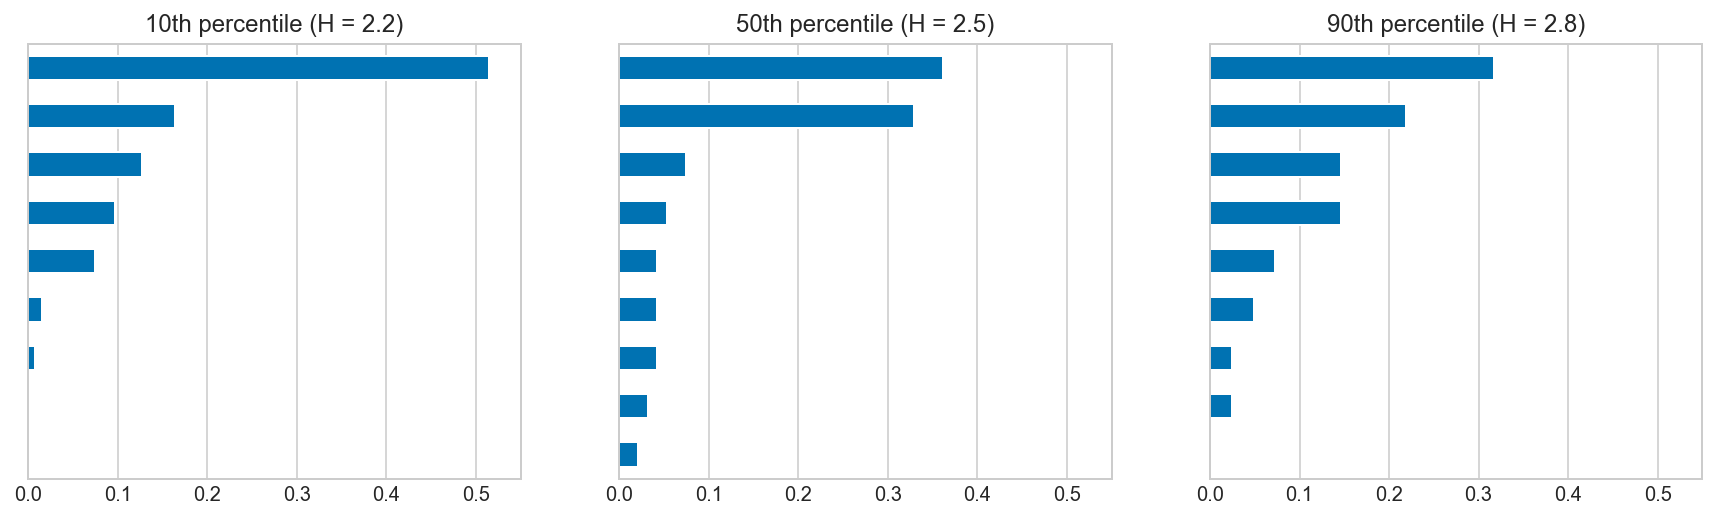

In [12]:
def make_spend_data(df):
    """Retains only spending transactions."""
    df = df[df.tag_group.eq("spend")].copy()
    df["tag"] = df.tag.cat.remove_unused_categories()
    return df


def entropy_pct_case_study(df, pct):
    """Returns first user-month with entropy score at specified percentile."""
    pct_val = np.nanpercentile(df.entropy_sptac, pct)
    pct_data = df[df.entropy_sptac.eq(pct_val)]
    pct_data = pct_data.set_index(["ym", "user_id"])
    first_user_month = pct_data.index.unique()[0]
    return pct_data.loc[first_user_month].reset_index()


def spend_breakdown(df, ax=None):
    """Plots breakdown of spending transactions across tags."""
    spend = df[df.tag_group.eq("spend")].copy()
    spend.tag.value_counts(ascending=True, normalize=True).plot(
        kind="barh", yticks=None, ax=ax
    )


def entropy_pct_case_studies(df, percentiles=None, figsize=(15, 4), **kwargs):
    """Shows spend txns breakdown for entropy percentiles sample users."""
    if percentiles is None:
        percentiles = [10, 50, 90]
    num_plots = len(percentiles)
    spend_data = make_spend_data(df)
    fig, ax = plt.subplots(1, num_plots, figsize=figsize, **kwargs)
    for i, pct in enumerate(percentiles):
        data = entropy_pct_case_study(spend_data, pct)
        entropy = data.entropy_sptac[0]
        title = f"{pct}th percentile (H = {entropy:.1f})"
        spend_breakdown(data, ax=ax[i])
        ax[i].set(title=title)
        ax[i].set_xlim(0, 0.55)
        ax[i].get_yaxis().set_ticks([])
    return fig, ax


entropy_pct_case_studies(df, percentiles=[10, 50, 90]);

## By year

We'd expect the cross-sectional distribution for different years to look very similar. The below figure confirms this.

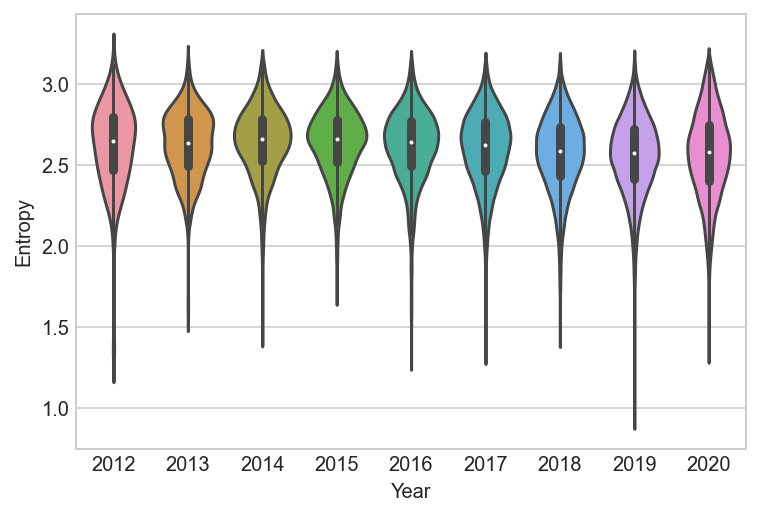

In [9]:
def make_data(df):
    return (
        df.groupby([df.date.dt.year, "user_id", "ym"])
        .entropy_sptac.first()
        .reset_index()
    )


def make_figure(data):
    fig, ax = plt.subplots()
    sns.violinplot(data=data, ax=ax, x="date", y="entropy_sptac")
    ax.set(xlabel="Year", ylabel="Entropy")


data = make_data(df)
make_figure(data)

## Within vs between variation

In [7]:
def make_data(df):
    month = pd.Grouper(key="date", freq="M")
    return (
        df.groupby(["user_id", month])
        .entropy_sptac.first()
        .reset_index()
        .set_index(["user_id", "date"], drop=False)
    )


data = make_data(df)
datas = make_data(dfs)
hd.inspect(data)

(79,966, 3)


user_id       date  entropy_sptac
user_id date                                         
107     2014-03-31      107 2014-03-31       2.036569
        2014-04-30      107 2014-04-30       2.282854

Variation in entropy between users accounts for about 45 percent of total variation.

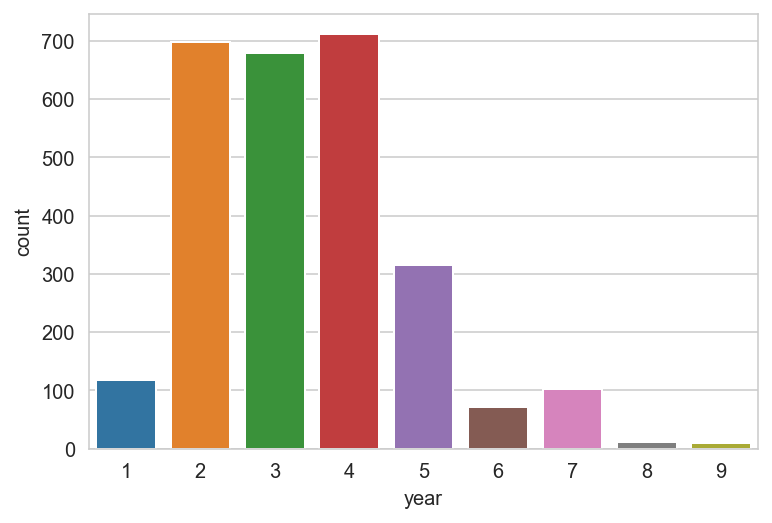

In [24]:
def num_years_observed(df):
    df["year"] = df.date.dt.year
    return df.groupby("user_id").year.nunique()


sns.countplot(x=num_years_observed(df));

In [20]:
resPanelOLS = lm.PanelOLS.from_formula("entropy_sptac ~ C(user_id)", data=data).fit()
resPanelOLSs = lm.PanelOLS.from_formula("entropy_sptac ~ C(user_id)", data=datas).fit()

In [35]:
lm.PanelOLS.from_formula("entropy_sptac ~ 1 + ", data=datas).fit(cov_type="clustered", cluster_entity=True)

Dep. Variable:,entropy_sptac,R-squared:,0.5425
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,788,R-squared (Within):,0.0000
Date:,"Wed, Dec 08 2021",R-squared (Overall):,0.5425
Time:,15:20:14,Log-likelihood,297.37
Cov. Estimator:,Clustered,,
,,F-statistic:,36.139
Entities:,26,P-value,0.0000
Avg Obs:,30.308,Distribution:,"F(25,762)"
Min Obs:,6.0000,,
Max Obs:,102.00,F-statistic (robust):,3.149e+28


In [30]:
print(
    lm.panel.compare(
        {"777 sample": resPanelOLSs, "XX7 sample": resPanelOLS}, stars=True
    )
)

                   Model Comparison                  
                           777 sample      XX7 sample
-----------------------------------------------------
Dep. Variable           entropy_sptac   entropy_sptac
Estimator                    PanelOLS        PanelOLS
No. Observations                  788           79966
Cov. Est.                  Unadjusted      Unadjusted
R-squared                      0.5425          0.4558
R-Squared (Within)             0.0000          0.0000
R-Squared (Between)            1.0000          1.0000
R-Squared (Overall)            0.5425          0.4558
F-statistic                    36.139          23.831
P-value (F-stat)               0.0000          0.0000
===================== =============== ===============
C(user_id)[777]             2.7645***       2.7645***
                             (165.49)        (158.72)
C(user_id)[58777]           2.7704***       2.7704***
                             (69.666)        (66.819)
C(user_id)[76777]           

Distribution of within-user variation

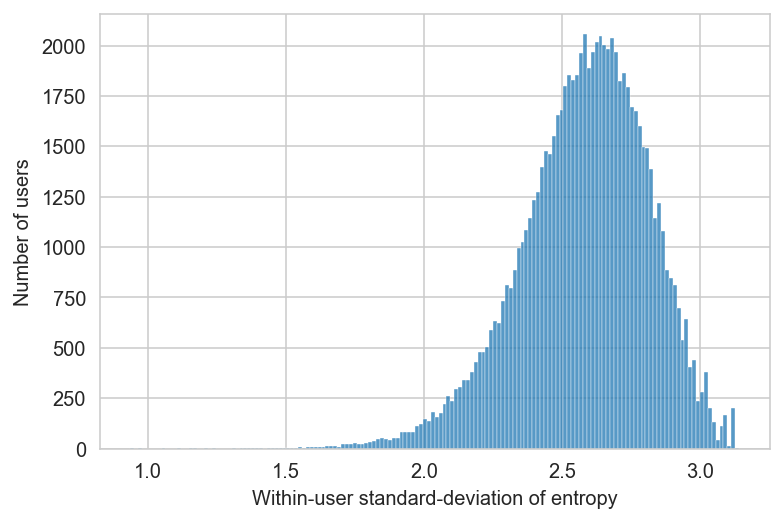

In [16]:
def make_figure(data):
    fig, ax = plt.subplots()
    sns.histplot(data=data, ax=ax, x="entropy_sptac")
    ax.set(ylabel="Number of users", xlabel="Within-user standard-deviation of entropy")


d = data.groupby(level="user_id").entropy_sptac.std().reset_index()
make_figure(data)